# Atlanta Police Department
![APD Logo](https://atlantapd.galls.com/photos/partners/atlantapd/logo.jpg)


The Atlanta Police Department provides Part 1 crime data at http://www.atlantapd.org/i-want-to/crime-data-downloads

A recent copy of the data file is stored in the cluster. <span style="color: red; font-weight: bold;">Please, do not copy this data file into your home directory!</span>

# Introduction


- This notebooks leads into an exploration of public crime data provided by the Atlanta Police Department.
- The original data set and supplemental information can be found at http://www.atlantapd.org/i-want-to/crime-data-downloads
- **The data set is available on ARC, please, don't download into your home directory on ARC!**

In [2]:
import numpy as np
import pandas as pd 
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
# load data set
df = pd.read_csv('/home/data/APD/COBRA-YTD-multiyear.csv.gz')
print "Shape of table: ", df.shape

Shape of table:  (285733, 23)


/usr/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Review: Creating a data key

Let's look at the structure of this table. We're actually creating some text output that can be used to create a data dictionary.

In [4]:
dataDict = pd.DataFrame({'DataType': df.dtypes.values, 'Description': '', }, index=df.columns.values)

We need to enter the descriptions for each entry in our dictionary manually...

In [6]:
dataDict.loc['MI_PRINX'].Description = '' # type: int64
dataDict.loc['offense_id'].Description = 'Unique ID in the format YYDDDNNNN with the year YY, the day of the year DDD and a counter NNNN' # type: int64
dataDict.loc['rpt_date'].Description = 'Date the crime was reported' # type: object
dataDict.loc['occur_date'].Description = 'Estimated date when the crime occured' # type: object
dataDict.loc['occur_time'].Description = 'Estimated time when the crime occured' # type: object
dataDict.loc['poss_date'].Description = '' # type: object
dataDict.loc['poss_time'].Description = '' # type: object
dataDict.loc['beat'].Description = '' # type: int64
dataDict.loc['apt_office_prefix'].Description = '' # type: object
dataDict.loc['apt_office_num'].Description = '' # type: object
dataDict.loc['location'].Description = '' # type: object
dataDict.loc['MinOfucr'].Description = '' # type: int64
dataDict.loc['MinOfibr_code'].Description = '' # type: object
dataDict.loc['dispo_code'].Description = '' # type: object
dataDict.loc['MaxOfnum_victims'].Description = '' # type: float64
dataDict.loc['Shift'].Description = 'Zones have 8 or 10 hour shifts' # type: object
dataDict.loc['Avg Day'].Description = '' # type: object
dataDict.loc['loc_type'].Description = '' # type: float64
dataDict.loc['UC2 Literal'].Description = '' # type: object
dataDict.loc['neighborhood'].Description = '' # type: object
dataDict.loc['npu'].Description = '' # type: object
dataDict.loc['x'].Description = '' # type: float64
dataDict.loc['y'].Description = '' # type: float64
dataDict.to_csv("COBRA_Data_Dictionary.csv")

In [7]:
dataDict

DataType                                        Description
MI_PRINX             int64                                                   
offense_id           int64  Unique ID in the format YYDDDNNNN with the yea...
rpt_date            object                        Date the crime was reported
occur_date          object              Estimated date when the crime occured
occur_time          object              Estimated time when the crime occured
poss_date           object                                                   
poss_time           object                                                   
beat               float64                                                   
apt_office_prefix   object                                                   
apt_office_num      object                                                   
location            object                                                   
MinOfucr             int64                                                   
MinOfibr_code       object                                                   
dispo_code          object                                                   
MaxOfnum_victims   float64                                                   
Shift               object                     Zones have 8 or 10 hour shifts
Avg Day             object                                                   
loc_type           float64                                                   
UC2 Literal         object                                                   
neighborhood        object                                                   
npu                 object                                                   
x                  float64                                                   
y                  float64

## Convert Time Columns

Please refer to the following resources for working with time series data in pandas:
- https://pandas.pydata.org/pandas-docs/stable/timeseries.html
- https://pandas.pydata.org/pandas-docs/stable/api.html#id10

In [10]:
# function currying
def fixdatetime(fld):
    def _fix(s):
        date_col = '%s_date' % fld # "rpt_date"
        time_col = '%s_time' % fld # "rpt_time"
        if time_col in s.index:
            return str(s[date_col])+' '+str(s[time_col])
        else:
            return str(s[date_col])+' 00:00:00'
    return _fix

In [11]:
for col in ['rpt', 'occur', 'poss']:
    datser = df.apply(fixdatetime(col), axis=1)
    df['%s_dt'%col] = pd.to_datetime(datser, format="%m/%d/%Y %H:%M:%S", errors='coerce')

In [12]:
df[["MI_PRINX", "offense_id", "beat", "UC2 Literal", "neighborhood", "rpt_dt", "occur_dt", "poss_dt"]].head()

MI_PRINX  offense_id   beat           UC2 Literal   neighborhood  \
0   1160569    90360664  305.0   LARCENY-NON VEHICLE  South Atlanta   
1   1160570    90370891  502.0  LARCENY-FROM VEHICLE    Ansley Park   
2   1160572    91681984  604.0   LARCENY-NON VEHICLE   Sweet Auburn   
3   1160575    82040835  104.0    BURGLARY-RESIDENCE    Mozley Park   
4   1160576    82922120  210.0            AUTO THEFT          Lenox   

      rpt_dt            occur_dt             poss_dt  
0 2009-02-05 2009-02-03 13:50:00 2009-02-03 15:00:00  
1 2009-02-06 2009-02-06 08:50:00 2009-02-06 10:45:00  
2 2009-06-17 2009-06-17 14:00:00 2009-06-17 15:00:00  
3 2009-02-27 2008-07-21 18:00:00 2008-07-21 18:00:00  
4 2009-01-14 2008-10-19 18:30:00 2008-10-19 19:45:00

What's the date range of the data?

In [13]:
print df.occur_dt.min(), '---', df.occur_dt.max()

1916-01-07 12:15:00 --- 2017-09-28 02:07:00


Number of crimes reported each year:

In [14]:
# resample is like "groupby" for time
df.resample('A-DEC', closed='right', on='occur_dt').offense_id.count()
# df['Year'] = df.occur_dt.map(lambda d: d.year)
# df2 = df[(df.Year>=2010) & (df.Year<=2017)]
# df2.shape, df.shape

occur_dt
1916-12-31       11
1917-12-31        0
1918-12-31        0
1919-12-31        0
1920-12-31        2
1921-12-31        0
1922-12-31        0
1923-12-31        0
1924-12-31        0
1925-12-31        0
1926-12-31        0
1927-12-31        0
1928-12-31        0
1929-12-31        0
1930-12-31        0
1931-12-31        0
1932-12-31        0
1933-12-31        0
1934-12-31        0
1935-12-31        0
1936-12-31        0
1937-12-31        0
1938-12-31        0
1939-12-31        0
1940-12-31        0
1941-12-31        0
1942-12-31        0
1943-12-31        0
1944-12-31        0
1945-12-31        0
              ...  
1988-12-31        0
1989-12-31        0
1990-12-31        0
1991-12-31        2
1992-12-31        0
1993-12-31        1
1994-12-31        1
1995-12-31        0
1996-12-31        2
1997-12-31        0
1998-12-31        1
1999-12-31        0
2000-12-31        3
2001-12-31        5
2002-12-31        3
2003-12-31        2
2004-12-31        4
2005-12-31        4
2006-12-31 

Looks like most of the data is actually from 2009-2017! Let's throw the rest away...

In [15]:
df = df[df.occur_dt>='01/01/2009']

# Crime Over Time

Has the number of crimes in Atlanta changed over time?

Are some areas more affected by crime than others?

Do different types of crime correlate with each other?

## Number of Crimes Over Time, with Pivot Tables

In [39]:
df[["occur_dt", "UC2 Literal", "offense_id"]].head()

occur_dt           UC2 Literal  offense_id
0  2009-02-03 13:50:00   LARCENY-NON VEHICLE    90360664
1  2009-02-06 08:50:00  LARCENY-FROM VEHICLE    90370891
2  2009-06-17 14:00:00   LARCENY-NON VEHICLE    91681984
13 2009-01-01 00:10:00    BURGLARY-RESIDENCE    90010061
18 2009-01-01 00:57:00    ROBBERY-PEDESTRIAN    90010159

In [115]:
# Pivoting the table:
# index = nolumn that the new table will be indexed by
# columns = column whose unique values will form the new column names
# values = values used to fill the table (default = all columns other than those given in index and columns)
df_ct = df.pivot_table(index="occur_dt", columns="UC2 Literal", values="offense_id")

In [116]:
df_ct.head()

UC2 Literal          AGG ASSAULT  AUTO THEFT  BURGLARY-NONRES  \
occur_dt                                                        
2009-01-01 00:00:00  153221163.0         NaN              NaN   
2009-01-01 00:01:00          NaN  90011439.0              NaN   
2009-01-01 00:10:00          NaN         NaN              NaN   
2009-01-01 00:15:00          NaN  90010545.0              NaN   
2009-01-01 00:30:00          NaN  90010358.0       90140681.0   

UC2 Literal          BURGLARY-RESIDENCE  HOMICIDE  LARCENY-FROM VEHICLE  \
occur_dt                                                                  
2009-01-01 00:00:00          91560871.0       NaN                   NaN   
2009-01-01 00:01:00          91681133.0       NaN                   NaN   
2009-01-01 00:10:00          90010061.0       NaN                   NaN   
2009-01-01 00:15:00                 NaN       NaN                   NaN   
2009-01-01 00:30:00                 NaN       NaN            90020660.0   

UC2 Literal          LARCENY-NON VEHICLE  RAPE  ROBBERY-COMMERCIAL  \
occur_dt                                                             
2009-01-01 00:00:00          110261152.0   NaN                 NaN   
2009-01-01 00:01:00                  NaN   NaN                 NaN   
2009-01-01 00:10:00                  NaN   NaN                 NaN   
2009-01-01 00:15:00                  NaN   NaN                 NaN   
2009-01-01 00:30:00           90030641.0   NaN                 NaN   

UC2 Literal          ROBBERY-PEDESTRIAN  ROBBERY-RESIDENCE  
occur_dt                                                    
2009-01-01 00:00:00                 NaN                NaN  
2009-01-01 00:01:00                 NaN                NaN  
2009-01-01 00:10:00                 NaN                NaN  
2009-01-01 00:15:00                 NaN                NaN  
2009-01-01 00:30:00                 NaN                NaN

This gives us a timeline for different types of crime reported in Atlanta.

By itself, this can be useful, but we are more interested in aggregate statistics. Let's get the number of crimes by month...

In [117]:
df_ct = df_ct.resample("1M", closed="right").count()

In [113]:
df_ct.head()

UC2 Literal  AGG ASSAULT  AUTO THEFT  BURGLARY-NONRES  BURGLARY-RESIDENCE  \
occur_dt                                                                    
2009-01-31           215         429              193                 546   
2009-02-28           197         334              110                 385   
2009-03-31           225         385               98                 448   
2009-04-30           224         406              124                 495   
2009-05-31           218         454              163                 519   

UC2 Literal  HOMICIDE  LARCENY-FROM VEHICLE  LARCENY-NON VEHICLE  RAPE  \
occur_dt                                                                 
2009-01-31          6                   705                  599    12   
2009-02-28          9                   600                  536     7   
2009-03-31          5                   619                  613     7   
2009-04-30          5                   610                  616     8   
2009-05-31          8                   751                  595    12   

UC2 Literal  ROBBERY-COMMERCIAL  ROBBERY-PEDESTRIAN  ROBBERY-RESIDENCE  
occur_dt                                                                
2009-01-31                   26                 204                 28  
2009-02-28                   14                 104                 19  
2009-03-31                   22                 139                 28  
2009-04-30                   26                 118                 22  
2009-05-31                   16                 151                 21

Average number of crimes per month, for each year:

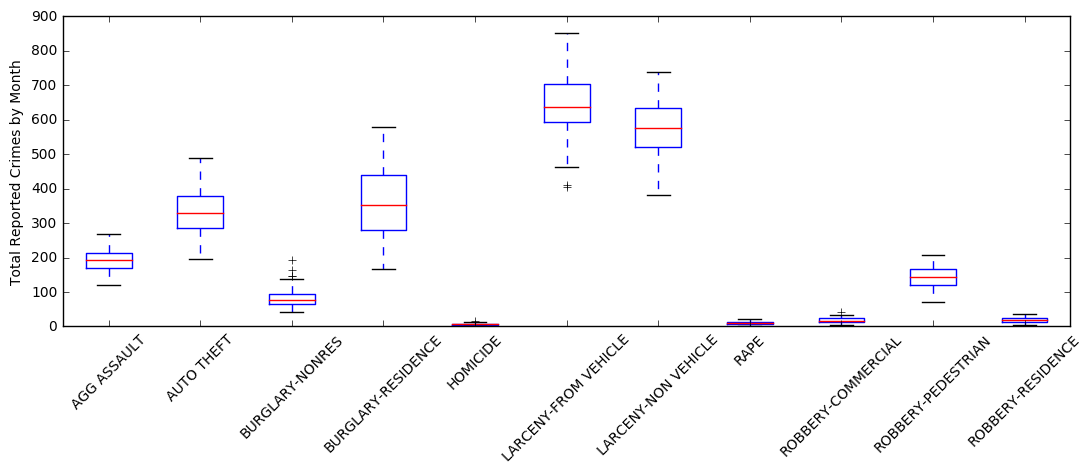

In [56]:
ax = df_ct.plot.box(figsize=(13,4), rot=45)
plt.ylabel("Total Reported Crimes by Month")

Explanation of boxplot:

From the matplotlib documentation (http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.boxplot):

The box extends from the **lower to upper quartile values** of the data, with a line at the **median**. The whiskers extend from the box to show the range of the data. Flier points are those past the end of the whiskers.

**Whiskers:** IQR is the interquartile range (Q3-Q1). The upper whisker will extend to last datum less than Q3 + whis*IQR (where the default value for whis is 1.5). Similarly, the lower whisker will extend to the first datum greater than Q1 - whis*IQR. Beyond the whiskers, data are considered outliers and are plotted as individual points. 

In [70]:
## In-class exercise:
# Make a boxplot of the number of reported crimes, aggregating by week. 

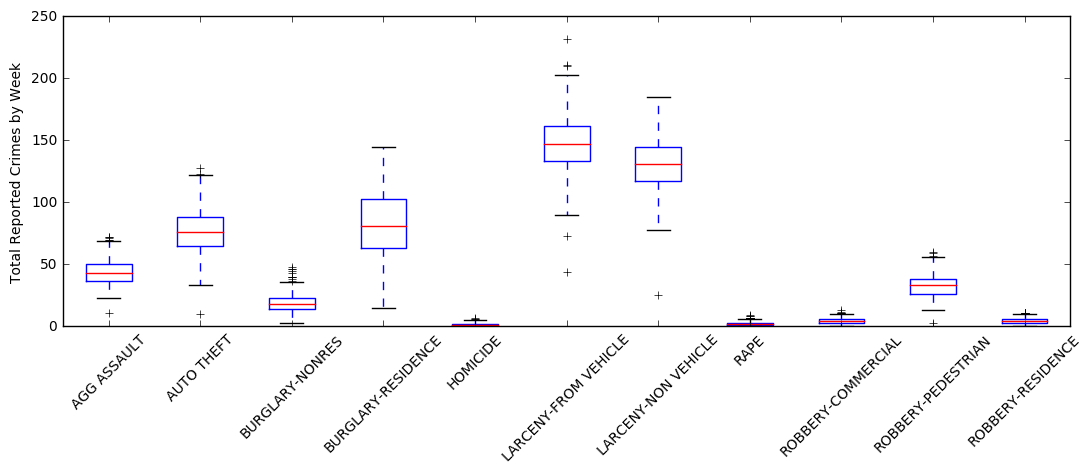

In [199]:
df_wk = df.pivot_table(index="occur_dt", columns="UC2 Literal", values="offense_id")
df_wk = df_wk.resample("W-SUN", closed='right').count()
df_wk.plot.box(figsize=(13,4), rot=45)
plt.ylabel("Total Reported Crimes by Week")

More on pandas datetime objects:

http://pandas-docs.github.io/pandas-docs-travis/timeseries.html#dateoffset-objects

http://pandas-docs.github.io/pandas-docs-travis/timeseries.html#anchored-offsets

### Crimes over time

Let's take a look at a time series plot of the number of crimes over time...

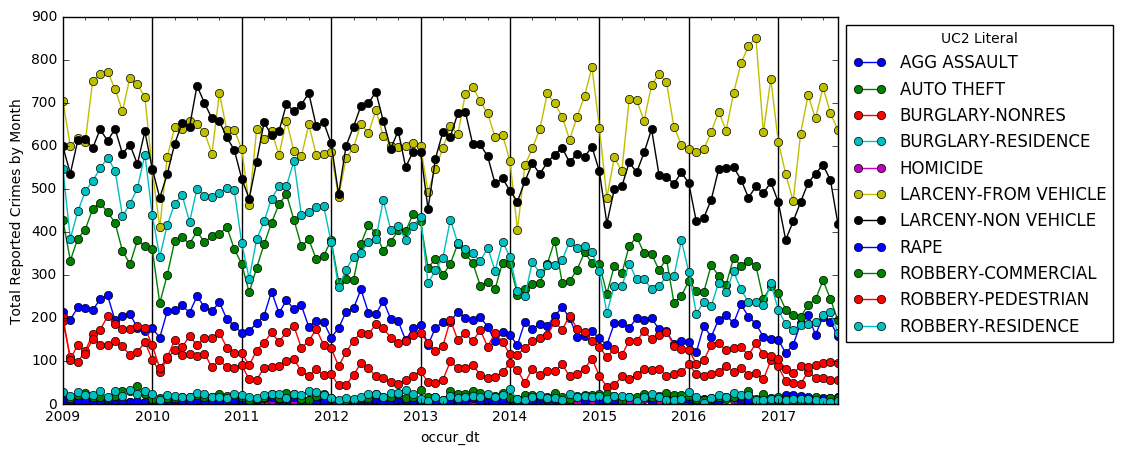

In [69]:
ax = df_ct.plot(figsize=(10,5), style='-o')
ax.get_legend().set_bbox_to_anchor((1, 1))
plt.ylabel("Total Reported Crimes by Month")
ax.vlines(pd.date_range("12/31/2009", "12/31/2017", freq="A-JAN"), 0, 900)

Can you pick out the seasonal variation in number of crimes per year?

Suppose we are not interested in seasonal trends, but want to see if the number of reported crimes is changing year over year. We could simply add the number of crimes together to get number of crimes reported each year.

In [61]:
ann_cr = df_ct.resample("A-DEC", closed="right").sum()

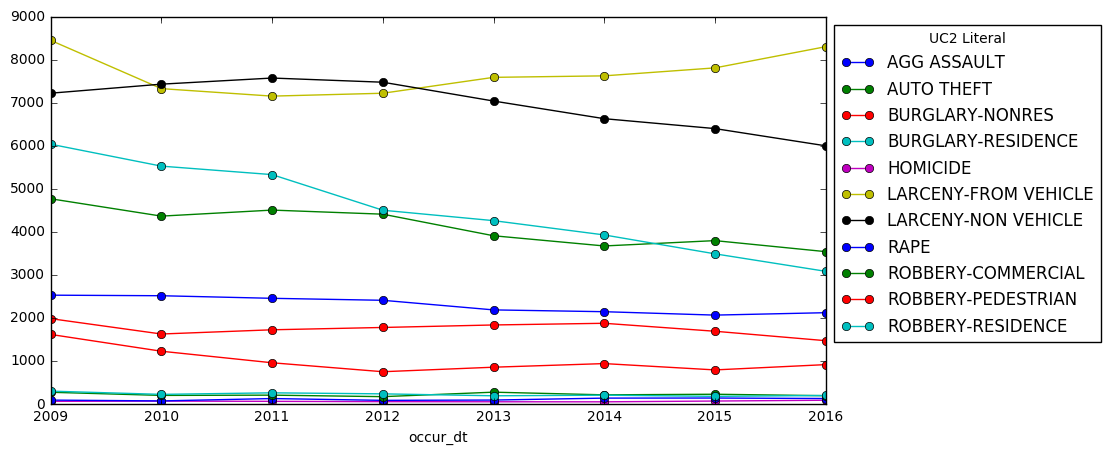

In [63]:
ax = ann_cr[ann_cr.index<"01/01/2017"].plot(figsize=(10,5), style='-o')
ax.get_legend().set_bbox_to_anchor((1, 1))

## Correlation In Number of Crimes Over Time

You can use the "corr" method in Pandas to find the correlation between columns of a dataframe. 

In [72]:
crime_corr = df_ct.corr()

In [73]:
crime_corr

UC2 Literal           AGG ASSAULT  AUTO THEFT  BURGLARY-NONRES  \
UC2 Literal                                                      
AGG ASSAULT              1.000000    0.576531         0.421596   
AUTO THEFT               0.576531    1.000000         0.533435   
BURGLARY-NONRES          0.421596    0.533435         1.000000   
BURGLARY-RESIDENCE       0.542202    0.803201         0.679169   
HOMICIDE                 0.149337    0.120529         0.112832   
LARCENY-FROM VEHICLE     0.338300    0.282402         0.383798   
LARCENY-NON VEHICLE      0.703525    0.713693         0.397397   
RAPE                    -0.186406   -0.291398        -0.106504   
ROBBERY-COMMERCIAL       0.107282    0.329893         0.301352   
ROBBERY-PEDESTRIAN       0.430136    0.619131         0.449046   
ROBBERY-RESIDENCE        0.245913    0.532972         0.446097   

UC2 Literal           BURGLARY-RESIDENCE  HOMICIDE  LARCENY-FROM VEHICLE  \
UC2 Literal                                                                
AGG ASSAULT                     0.542202  0.149337              0.338300   
AUTO THEFT                      0.803201  0.120529              0.282402   
BURGLARY-NONRES                 0.679169  0.112832              0.383798   
BURGLARY-RESIDENCE              1.000000  0.049407              0.134727   
HOMICIDE                        0.049407  1.000000              0.190973   
LARCENY-FROM VEHICLE            0.134727  0.190973              1.000000   
LARCENY-NON VEHICLE             0.735370  0.102213              0.264205   
RAPE                           -0.378922  0.027382              0.133064   
ROBBERY-COMMERCIAL              0.366299  0.050653              0.344469   
ROBBERY-PEDESTRIAN              0.619963  0.120625              0.432473   
ROBBERY-RESIDENCE               0.602774  0.098739              0.152859   

UC2 Literal           LARCENY-NON VEHICLE      RAPE  ROBBERY-COMMERCIAL  \
UC2 Literal                                                               
AGG ASSAULT                      0.703525 -0.186406            0.107282   
AUTO THEFT                       0.713693 -0.291398            0.329893   
BURGLARY-NONRES                  0.397397 -0.106504            0.301352   
BURGLARY-RESIDENCE               0.735370 -0.378922            0.366299   
HOMICIDE                         0.102213  0.027382            0.050653   
LARCENY-FROM VEHICLE             0.264205  0.133064            0.344469   
LARCENY-NON VEHICLE              1.000000 -0.289339            0.249787   
RAPE                            -0.289339  1.000000           -0.223143   
ROBBERY-COMMERCIAL               0.249787 -0.223143            1.000000   
ROBBERY-PEDESTRIAN               0.614282 -0.189692            0.518056   
ROBBERY-RESIDENCE                0.449193 -0.225600            0.273413   

UC2 Literal           ROBBERY-PEDESTRIAN  ROBBERY-RESIDENCE  
UC2 Literal                                                  
AGG ASSAULT                     0.430136           0.245913  
AUTO THEFT                      0.619131           0.532972  
BURGLARY-NONRES                 0.449046           0.446097  
BURGLARY-RESIDENCE              0.619963           0.602774  
HOMICIDE                        0.120625           0.098739  
LARCENY-FROM VEHICLE            0.432473           0.152859  
LARCENY-NON VEHICLE             0.614282           0.449193  
RAPE                           -0.189692          -0.225600  
ROBBERY-COMMERCIAL              0.518056           0.273413  
ROBBERY-PEDESTRIAN              1.000000           0.406093  
ROBBERY-RESIDENCE               0.406093           1.000000

Visualizing the correlation...

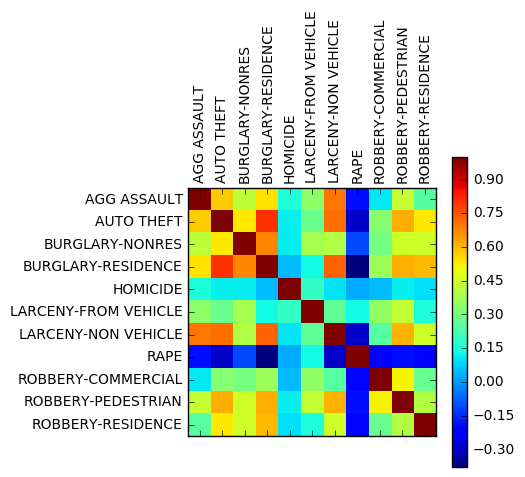

In [83]:
plt.matshow(crime_corr);
plt.yticks(range(len(crime_corr.columns)), crime_corr.columns);
plt.xticks(range(len(crime_corr.columns)), crime_corr.columns, rotation=90);
plt.colorbar();

# Crimes By Place

## Beats and Zones
The City of Atlanta is divided into 6 zones, each with 12 to 14 beats. 

![](https://upload.wikimedia.org/wikipedia/commons/thumb/c/cb/Atlanta_Police_Zones_-_Feb_2013.jpg/588px-Atlanta_Police_Zones_-_Feb_2013.jpg)

In [132]:
df['Zone'] = df['beat']//100
df['Year'] = df.occur_dt.apply(lambda x: x.year)

In [202]:
df_cp = df.pivot_table(index="Zone", 
                       columns="UC2 Literal", 
                       values="offense_id", 
                       aggfunc=lambda x: np.count_nonzero(~np.isnan(x)))

In [203]:
df_cp

UC2 Literal  AGG ASSAULT  AUTO THEFT  BURGLARY-NONRES  BURGLARY-RESIDENCE  \
Zone                                                                        
0.0                  7.0        36.0              4.0                 NaN   
1.0               5492.0      7031.0           1307.0              9996.0   
2.0               1246.0      4504.0           1877.0              5113.0   
3.0               5350.0      8762.0           1667.0             10206.0   
4.0               4336.0      8491.0           1536.0             11240.0   
5.0               1892.0      4589.0           1123.0              1420.0   
6.0               2032.0      6328.0           1383.0              6284.0   
7.0                 27.0        99.0              8.0                 NaN   
9.0                  NaN         NaN              NaN                 NaN   

UC2 Literal  HOMICIDE  LARCENY-FROM VEHICLE  LARCENY-NON VEHICLE   RAPE  \
Zone                                                                      
0.0               NaN                  83.0                336.0    NaN   
1.0             191.0                7881.0               8589.0  236.0   
2.0              25.0               18330.0              16094.0  144.0   
3.0             172.0                8363.0               8390.0  229.0   
4.0             131.0                9389.0              10690.0  188.0   
5.0              49.0               22158.0              12545.0  172.0   
6.0              72.0               16201.0              10440.0  121.0   
7.0               NaN                 270.0               1279.0    2.0   
9.0               NaN                   1.0                  NaN    NaN   

UC2 Literal  ROBBERY-COMMERCIAL  ROBBERY-PEDESTRIAN  ROBBERY-RESIDENCE  
Zone                                                                    
0.0                         NaN                 2.0                NaN  
1.0                       202.0              3122.0              474.0  
2.0                       401.0              1259.0              205.0  
3.0                       327.0              3129.0              455.0  
4.0                       399.0              2894.0              443.0  
5.0                       241.0              2322.0              128.0  
6.0                       357.0              2345.0              246.0  
7.0                         NaN                 6.0                NaN  
9.0                         NaN                 NaN                NaN

In [218]:
df_cp = df.pivot_table(index=["Year","Zone"], 
                       columns="UC2 Literal", 
                       values="offense_id", 
                       aggfunc=lambda x: np.count_nonzero(~np.isnan(x)))

In [219]:
df_cp

UC2 Literal  AGG ASSAULT  AUTO THEFT  BURGLARY-NONRES  BURGLARY-RESIDENCE  \
Year Zone                                                                   
2009 0.0             4.0        21.0              2.0                 NaN   
     1.0           674.0      1045.0            262.0              1564.0   
     2.0           162.0       522.0            347.0               744.0   
     3.0           650.0      1256.0            266.0              1695.0   
     4.0           513.0      1078.0            282.0              1976.0   
     5.0           241.0       839.0            230.0               252.0   
     6.0           346.0       880.0            293.0              1163.0   
     7.0             NaN         3.0              NaN                 NaN   
2010 0.0             3.0        15.0              2.0                 NaN   
     1.0           777.0       771.0            204.0              1618.0   
     2.0           131.0       611.0            233.0               746.0   
     3.0           662.0      1077.0            234.0              1627.0   
     4.0           524.0      1129.0            240.0              1695.0   
     5.0           222.0       589.0            162.0               154.0   
     6.0           271.0       812.0            198.0               873.0   
     7.0             NaN         4.0              NaN                 NaN   
2011 1.0           667.0       973.0            154.0              1457.0   
     2.0           145.0       545.0            175.0               643.0   
     3.0           681.0      1105.0            229.0              1645.0   
     4.0           547.0      1090.0            210.0              1680.0   
     5.0           225.0       647.0            112.0               166.0   
     6.0           246.0       845.0            114.0               818.0   
     7.0             4.0        30.0              NaN                 NaN   
2012 1.0           656.0      1037.0            116.0              1284.0   
     2.0           158.0       487.0            168.0               699.0   
     3.0           622.0      1171.0            157.0              1284.0   
     4.0           543.0      1010.0            117.0              1237.0   
     5.0           209.0       475.0             96.0               172.0   
     6.0           266.0       887.0            119.0               578.0   
     7.0             4.0        30.0              2.0                 NaN   
...                  ...         ...              ...                 ...   
2013 7.0             3.0         8.0              1.0                 NaN   
     9.0             NaN         NaN              NaN                 NaN   
2014 1.0           565.0       703.0            128.0               937.0   
     2.0           139.0       423.0            224.0               497.0   
     3.0           622.0       841.0            206.0              1080.0   
     4.0           453.0       957.0            148.0              1145.0   
     5.0           213.0       480.0            121.0               140.0   
     6.0           190.0       717.0            139.0               644.0   
     7.0             1.0         9.0              2.0                 NaN   
2015 1.0           523.0       705.0            110.0               855.0   
     2.0           138.0       472.0            208.0               507.0   
     3.0           586.0       971.0            151.0               846.0   
     4.0           456.0       945.0            125.0               939.0   
     5.0           226.0       469.0             90.0               189.0   
     6.0           177.0       650.0            128.0               583.0   
     7.0             5.0         6.0              NaN                 NaN   
2016 1.0           621.0       707.0            109.0               762.0   
     2.0           129.0       615.0            245.0               502.0   
     3.0           599.0       778.0            142.0               628.0

In [160]:
df_cp = df_cp[np.logical_and([x >= 1 for x in zip(*df_cp.index.values)[1]], 
                             [x <= 6 for x in zip(*df_cp.index.values)[1]])].fillna(0)
df_cp.head(20)

UC2 Literal  AGG ASSAULT  AUTO THEFT  BURGLARY-NONRES  BURGLARY-RESIDENCE  \
Year Zone                                                                   
2009 1.0           674.0      1045.0            262.0              1564.0   
     2.0           162.0       522.0            347.0               744.0   
     3.0           650.0      1256.0            266.0              1695.0   
     4.0           513.0      1078.0            282.0              1976.0   
     5.0           241.0       839.0            230.0               252.0   
     6.0           346.0       880.0            293.0              1163.0   
2010 1.0           777.0       771.0            204.0              1618.0   
     2.0           131.0       611.0            233.0               746.0   
     3.0           662.0      1077.0            234.0              1627.0   
     4.0           524.0      1129.0            240.0              1695.0   
     5.0           222.0       589.0            162.0               154.0   
     6.0           271.0       812.0            198.0               873.0   
2011 1.0           667.0       973.0            154.0              1457.0   
     2.0           145.0       545.0            175.0               643.0   
     3.0           681.0      1105.0            229.0              1645.0   
     4.0           547.0      1090.0            210.0              1680.0   
     5.0           225.0       647.0            112.0               166.0   
     6.0           246.0       845.0            114.0               818.0   
2012 1.0           656.0      1037.0            116.0              1284.0   
     2.0           158.0       487.0            168.0               699.0   

UC2 Literal  HOMICIDE  LARCENY-FROM VEHICLE  LARCENY-NON VEHICLE  RAPE  \
Year Zone                                                                
2009 1.0         19.0                1102.0               1037.0  25.0   
     2.0          4.0                2203.0               2149.0  10.0   
     3.0         20.0                 841.0               1031.0  28.0   
     4.0         14.0                1148.0               1202.0  14.0   
     5.0          5.0                3333.0               1529.0  13.0   
     6.0          8.0                2342.0               1338.0   9.0   
2010 1.0         24.0                 855.0               1110.0   6.0   
     2.0          5.0                2152.0               1902.0  16.0   
     3.0         21.0                 854.0               1213.0  20.0   
     4.0         15.0                 971.0               1476.0  19.0   
     5.0          5.0                2632.0               1543.0   8.0   
     6.0         10.0                1714.0               1263.0  11.0   
2011 1.0         23.0                 861.0               1163.0  31.0   
     2.0          1.0                1662.0               1859.0  16.0   
     3.0         18.0                 928.0               1293.0  35.0   
     4.0         15.0                 969.0               1381.0  26.0   
     5.0          6.0                2526.0               1593.0  11.0   
     6.0         12.0                1642.0               1429.0  16.0   
2012 1.0         20.0                 886.0               1013.0  16.0   
     2.0          0.0                2123.0               1817.0   8.0   

UC2 Literal  ROBBERY-COMMERCIAL  ROBBERY-PEDESTRIAN  ROBBERY-RESIDENCE  
Year Zone                                                               
2009 1.0                   27.0               464.0               77.0  
     2.0                   67.0               120.0               42.0  
     3.0                   46.0               402.0               74.0  
     4.0                   50.0               370.0               65.0  
     5.0                   25.0               337.0               17.0  
     6.0                   66.0               323.0               34.0  
2010 1.0                   23.0               346.0               53.0  
     2.0           

In [224]:
# A MUCH PRETTIER way to do the same thing:
df_cp = df_cp.loc[(slice(None), slice(1,6)),:].fillna(0)
df_cp.head(20)

UC2 Literal  AGG ASSAULT  AUTO THEFT  BURGLARY-NONRES  BURGLARY-RESIDENCE  \
Year Zone                                                                   
2009 1.0           674.0      1045.0            262.0              1564.0   
     2.0           162.0       522.0            347.0               744.0   
     3.0           650.0      1256.0            266.0              1695.0   
     4.0           513.0      1078.0            282.0              1976.0   
     5.0           241.0       839.0            230.0               252.0   
     6.0           346.0       880.0            293.0              1163.0   
2010 1.0           777.0       771.0            204.0              1618.0   
     2.0           131.0       611.0            233.0               746.0   
     3.0           662.0      1077.0            234.0              1627.0   
     4.0           524.0      1129.0            240.0              1695.0   
     5.0           222.0       589.0            162.0               154.0   
     6.0           271.0       812.0            198.0               873.0   
2011 1.0           667.0       973.0            154.0              1457.0   
     2.0           145.0       545.0            175.0               643.0   
     3.0           681.0      1105.0            229.0              1645.0   
     4.0           547.0      1090.0            210.0              1680.0   
     5.0           225.0       647.0            112.0               166.0   
     6.0           246.0       845.0            114.0               818.0   
2012 1.0           656.0      1037.0            116.0              1284.0   
     2.0           158.0       487.0            168.0               699.0   

UC2 Literal  HOMICIDE  LARCENY-FROM VEHICLE  LARCENY-NON VEHICLE  RAPE  \
Year Zone                                                                
2009 1.0         19.0                1102.0               1037.0  25.0   
     2.0          4.0                2203.0               2149.0  10.0   
     3.0         20.0                 841.0               1031.0  28.0   
     4.0         14.0                1148.0               1202.0  14.0   
     5.0          5.0                3333.0               1529.0  13.0   
     6.0          8.0                2342.0               1338.0   9.0   
2010 1.0         24.0                 855.0               1110.0   6.0   
     2.0          5.0                2152.0               1902.0  16.0   
     3.0         21.0                 854.0               1213.0  20.0   
     4.0         15.0                 971.0               1476.0  19.0   
     5.0          5.0                2632.0               1543.0   8.0   
     6.0         10.0                1714.0               1263.0  11.0   
2011 1.0         23.0                 861.0               1163.0  31.0   
     2.0          1.0                1662.0               1859.0  16.0   
     3.0         18.0                 928.0               1293.0  35.0   
     4.0         15.0                 969.0               1381.0  26.0   
     5.0          6.0                2526.0               1593.0  11.0   
     6.0         12.0                1642.0               1429.0  16.0   
2012 1.0         20.0                 886.0               1013.0  16.0   
     2.0          0.0                2123.0               1817.0   8.0   

UC2 Literal  ROBBERY-COMMERCIAL  ROBBERY-PEDESTRIAN  ROBBERY-RESIDENCE  
Year Zone                                                               
2009 1.0                   27.0               464.0               77.0  
     2.0                   67.0               120.0               42.0  
     3.0                   46.0               402.0               74.0  
     4.0                   50.0               370.0               65.0  
     5.0                   25.0               337.0               17.0  
     6.0                   66.0               323.0               34.0  
2010 1.0                   23.0               346.0               53.0  
     2.0           

In [223]:
## slicing on a multi-index
#  get data for 2009-2010, for zones 1-3 
df_cp.loc[(slice(2009,2010), slice(1,5,2)),:]

UC2 Literal  AGG ASSAULT  AUTO THEFT  BURGLARY-NONRES  BURGLARY-RESIDENCE  \
Year Zone                                                                   
2009 1.0           674.0      1045.0            262.0              1564.0   
     3.0           650.0      1256.0            266.0              1695.0   
     5.0           241.0       839.0            230.0               252.0   
2010 1.0           777.0       771.0            204.0              1618.0   
     3.0           662.0      1077.0            234.0              1627.0   
     5.0           222.0       589.0            162.0               154.0   
2011 1.0           667.0       973.0            154.0              1457.0   
     3.0           681.0      1105.0            229.0              1645.0   
     5.0           225.0       647.0            112.0               166.0   
2012 1.0           656.0      1037.0            116.0              1284.0   
     3.0           622.0      1171.0            157.0              1284.0   
     5.0           209.0       475.0             96.0               172.0   
2013 1.0           579.0       739.0            152.0              1081.0   
     3.0           560.0      1068.0            179.0              1050.0   
     5.0           213.0       447.0            103.0               138.0   
2014 1.0           565.0       703.0            128.0               937.0   
     3.0           622.0       841.0            206.0              1080.0   
     5.0           213.0       480.0            121.0               140.0   
2015 1.0           523.0       705.0            110.0               855.0   
     3.0           586.0       971.0            151.0               846.0   
     5.0           226.0       469.0             90.0               189.0   
2016 1.0           621.0       707.0            109.0               762.0   
     3.0           599.0       778.0            142.0               628.0   
     5.0           189.0       364.0            146.0               140.0   
2017 1.0           430.0       351.0             72.0               438.0   
     3.0           368.0       495.0            103.0               351.0   
     5.0           154.0       279.0             63.0                69.0   

UC2 Literal  HOMICIDE  LARCENY-FROM VEHICLE  LARCENY-NON VEHICLE  RAPE  \
Year Zone                                                                
2009 1.0         19.0                1102.0               1037.0  25.0   
     3.0         20.0                 841.0               1031.0  28.0   
     5.0          5.0                3333.0               1529.0  13.0   
2010 1.0         24.0                 855.0               1110.0   6.0   
     3.0         21.0                 854.0               1213.0  20.0   
     5.0          5.0                2632.0               1543.0   8.0   
2011 1.0         23.0                 861.0               1163.0  31.0   
     3.0         18.0                 928.0               1293.0  35.0   
     5.0          6.0                2526.0               1593.0  11.0   
2012 1.0         20.0                 886.0               1013.0  16.0   
     3.0         16.0                 762.0               1050.0  16.0   
     5.0          4.0                2274.0               1545.0   9.0   
2013 1.0         20.0                 665.0               1043.0  19.0   
     3.0          9.0                 975.0                980.0  28.0   
     5.0          5.0                2600.0               1510.0  10.0   
2014 1.0         17.0                 753.0               1006.0  41.0   
     3.0         23.0                1129.0                820.0  23.0   
     5.0          6.0                2705.0               1435.0  20.0   
2015 1.0         25.0                1034.0                906.0  26.0   
     3.0         20.0                 978.0                758.0  33.0   
     5.0          6.0                2373.0               1371.0  37.0   
2016 1.0         26.0                1108.0                797.0

In [ ]:
## In-class exercise:
# Show all robbery data for 2011, 2013, and 2015, for zones 4-6 

In [226]:
df_cp.loc[(slice(2011,2015,2), slice(4,6)), "ROBBERY-COMMERCIAL":"ROBBERY-RESIDENCE"]

UC2 Literal  ROBBERY-COMMERCIAL  ROBBERY-PEDESTRIAN  ROBBERY-RESIDENCE
Year Zone                                                             
2011 4.0                   44.0               325.0               53.0
     5.0                   20.0               250.0               22.0
     6.0                   39.0               300.0               31.0
2013 4.0                   69.0               408.0               53.0
     5.0                   46.0               256.0               13.0
     6.0                   44.0               328.0               25.0
2015 4.0                   53.0               329.0               48.0
     5.0                   34.0               283.0               13.0
     6.0                   45.0               240.0               15.0

In [240]:
df_cp.filter(like='ROBBERY').loc[(slice(2011,2015,2), slice(4,6)), :]

UC2 Literal  ROBBERY-COMMERCIAL  ROBBERY-PEDESTRIAN  ROBBERY-RESIDENCE
Year Zone                                                             
2011 4.0                   44.0               325.0               53.0
     5.0                   20.0               250.0               22.0
     6.0                   39.0               300.0               31.0
2013 4.0                   69.0               408.0               53.0
     5.0                   46.0               256.0               13.0
     6.0                   44.0               328.0               25.0
2015 4.0                   53.0               329.0               48.0
     5.0                   34.0               283.0               13.0
     6.0                   45.0               240.0               15.0

In [242]:
## In-class exercise:
# Count the total number of crimes in each zone
df_cp.groupby(level=1).sum()

UC2 Literal  AGG ASSAULT  AUTO THEFT  BURGLARY-NONRES  BURGLARY-RESIDENCE  \
Zone                                                                        
1.0               5492.0      7031.0           1307.0              9996.0   
2.0               1246.0      4504.0           1877.0              5113.0   
3.0               5350.0      8762.0           1667.0             10206.0   
4.0               4336.0      8491.0           1536.0             11240.0   
5.0               1892.0      4589.0           1123.0              1420.0   
6.0               2032.0      6328.0           1383.0              6284.0   

UC2 Literal  HOMICIDE  LARCENY-FROM VEHICLE  LARCENY-NON VEHICLE   RAPE  \
Zone                                                                      
1.0             191.0                7881.0               8589.0  236.0   
2.0              25.0               18330.0              16094.0  144.0   
3.0             172.0                8363.0               8390.0  229.0   
4.0             131.0                9389.0              10690.0  188.0   
5.0              49.0               22158.0              12545.0  172.0   
6.0              72.0               16201.0              10440.0  121.0   

UC2 Literal  ROBBERY-COMMERCIAL  ROBBERY-PEDESTRIAN  ROBBERY-RESIDENCE  
Zone                                                                    
1.0                       202.0              3122.0              474.0  
2.0                       401.0              1259.0              205.0  
3.0                       327.0              3129.0              455.0  
4.0                       399.0              2894.0              443.0  
5.0                       241.0              2322.0              128.0  
6.0                       357.0              2345.0              246.0

In [251]:
help(df_cp.plot)

Help on FramePlotMethods in module pandas.tools.plotting object:

class FramePlotMethods(BasePlotMethods)
 |  DataFrame plotting accessor and method
 |  
 |  Examples
 |  --------
 |  >>> df.plot.line()
 |  >>> df.plot.scatter('x', 'y')
 |  >>> df.plot.hexbin()
 |  
 |  These plotting methods can also be accessed by calling the accessor as a
 |  method with the ``kind`` argument:
 |  ``df.plot(kind='line')`` is equivalent to ``df.plot.line()``
 |  
 |  Method resolution order:
 |      FramePlotMethods
 |      BasePlotMethods
 |      pandas.core.base.PandasObject
 |      pandas.core.base.StringMixin
 |      __builtin__.object
 |  
 |  Methods defined here:
 |  
 |  __call__(self, x=None, y=None, kind='line', ax=None, subplots=False, sharex=None, sharey=False, layout=None, figsize=None, use_index=True, title=None, grid=None, legend=True, style=None, logx=False, logy=False, loglog=False, xticks=None, yticks=None, xlim=None, ylim=None, rot=None, fontsize=None, colormap=None, table=False, y

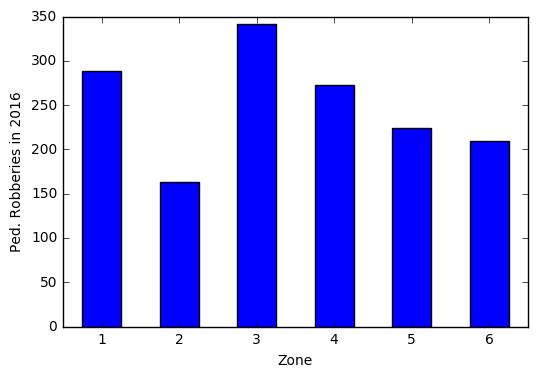

In [250]:
## In-class exercise:
# Plot the number of pedestrian robberies in each zone in 2016
df_cp.loc[(slice(2016,2016), slice(None)), "ROBBERY-PEDESTRIAN"].plot.bar()
plt.xticks(range(6), range(1,7), rotation=0);
plt.xlabel("Zone");
plt.ylabel("Ped. Robberies in 2016");

In [ ]:
## In-class exercise:
# What is the average annual number of crimes in each zone (for each type of crime)?
# Hint: use "groupby" with a "level" argument.

In [254]:
df_cp.groupby(level=1).mean()

UC2 Literal  AGG ASSAULT  AUTO THEFT  BURGLARY-NONRES  BURGLARY-RESIDENCE  \
Zone                                                                        
1.0           610.222222  781.222222       145.222222         1110.666667   
2.0           138.444444  500.444444       208.555556          568.111111   
3.0           594.444444  973.555556       185.222222         1134.000000   
4.0           481.777778  943.444444       170.666667         1248.888889   
5.0           210.222222  509.888889       124.777778          157.777778   
6.0           225.777778  703.111111       153.666667          698.222222   

UC2 Literal   HOMICIDE  LARCENY-FROM VEHICLE  LARCENY-NON VEHICLE       RAPE  \
Zone                                                                           
1.0          21.222222            875.666667           954.333333  26.222222   
2.0           2.777778           2036.666667          1788.222222  16.000000   
3.0          19.111111            929.222222           932.222222  25.444444   
4.0          14.555556           1043.222222          1187.777778  20.888889   
5.0           5.444444           2462.000000          1393.888889  19.111111   
6.0           8.000000           1800.111111          1160.000000  13.444444   

UC2 Literal  ROBBERY-COMMERCIAL  ROBBERY-PEDESTRIAN  ROBBERY-RESIDENCE  
Zone                                                                    
1.0                   22.444444          346.888889          52.666667  
2.0                   44.555556          139.888889          22.777778  
3.0                   36.333333          347.666667          50.555556  
4.0                   44.333333          321.555556          49.222222  
5.0                   26.777778          258.000000          14.222222  
6.0                   39.666667          260.555556          27.333333

In [ ]:
##### Shapefile stuff ########

In [196]:
import sys
try:
    from osgeo import ogr, osr, gdal
except:
    sys.exit('ERROR: cannot find GDAL/OGR modules')